In [70]:
import os
os.chdir('/home/reinfris/Repos/MPC')

In [71]:
from git import Repo
import subprocess

cwd = os.getcwd()

acados_path = os.path.join(cwd, 'acados')
build_path = os.path.join(acados_path, 'build')
acados_template_path = os.path.join(acados_path, 'interfaces', 'acados_template')

try:
    repo = Repo.clone_from('https://github.com/acados/acados.git', acados_path)
    output = repo.git.submodule('update', '--recursive', '--init')

    if not os.path.isdir(build_path):
        os.mkdir(build_path)

    os.chdir(build_path)

    print('go to ', build_path)

    subprocess.run(['cmake','-DACADOS_WITH_QPOASES=ON', '..'], stdout=subprocess.PIPE, text=True)
    subprocess.run(['make','install', '-j4'], stdout=subprocess.PIPE, text=True)
    os.chdir(cwd)
    subprocess.run(['pipenv', 'install', '--skip-lock', acados_template_path], stdout=subprocess.PIPE, text=True)

    print('export LD_LIBRARY_PATH=$LD_LIBRARY_PATH:'"'{acados_path}/lib'"'')
    print('export ACADOS_SOURCE_DIR='"'{acados_path}'"'') 

# export LD_LIBRARY_PATH=$LD_LIBRARY_PATH:"/usr/bin/acados/acados/lib"; export ACADOS_SOURCE_DIR="/usr/bin/acados/acados"
except:
    pass

In [72]:
import numpy as np
import sympy as sp
import sys
# from casadi import *
import casadi as cs
from acados_template import AcadosOcp, AcadosOcpSolver, AcadosModel
from scipy.linalg import block_diag
from scipy.integrate import odeint
import do_mpc

import matplotlib.pyplot as plt
import matplotlib as mpl

In [73]:
def skew_symmetric(v):
    """
    Computes the skew-symmetric matrix of a 3D vector (PAMPC version)
    :param v: 3D numpy vector or CasADi MX
    :return: the corresponding skew-symmetric matrix of v with the same data type as v
    """

    return np.array([[0, -v[0], -v[1], -v[2]],
                      [v[0], 0, v[2], -v[1]],
                      [v[1], -v[2], 0, v[0]],
                      [v[2], v[1], -v[0], 0]])
    
def kronecker(p):
    p0, p1, p2, p3 = p
    return sp.Matrix(
        [
            [p0, -p1, -p2, -p3],
            [p1, p0, p3, -p2],
            [p2, -p3, p0, p1],
            [p3, p2, -p1, p0]
        ]
    )

def q_to_rot_mat(q):
    qw, qx, qy, qz = q[0], q[1], q[2], q[3]

    rot_mat = sp.Matrix([
        [1 - 2 * (qy ** 2 + qz ** 2), 2 * (qx * qy - qw * qz), 2 * (qx * qz + qw * qy)],
        [2 * (qx * qy + qw * qz), 1 - 2 * (qx ** 2 + qz ** 2), 2 * (qy * qz - qw * qx)],
        [2 * (qx * qz - qw * qy), 2 * (qy * qz + qw * qx), 1 - 2 * (qx ** 2 + qy ** 2)]])

    return rot_mat


def v_dot_q(v, q):
    rot_mat = q_to_rot_mat(q)
    if isinstance(q, np.ndarray):
        return rot_mat.dot(v)

    return cs.mtimes(rot_mat, v)


def normalize(*args):
    arr = np.array(args)
    return np.divide(arr, np.linalg.norm(arr))


def quaternion_inverse(q):
    w, x, y, z = q[0], q[1], q[2], q[3]

    if isinstance(q, np.ndarray):
        return np.array([w, -x, -y, -z])
    else:
        return cs.vertcat(w, -x, -y, -z)

def q_dot_q(q, r):
    """
    Applies the rotation of quaternion r to quaternion q. In order words, rotates quaternion q by r. Quaternion format:
    wxyz.

    :param q: 4-length numpy array or CasADi MX. Initial rotation
    :param r: 4-length numpy array or CasADi MX. Applied rotation
    :return: The quaternion q rotated by r, with the same format as in the input.
    """

    qw, qx, qy, qz = q[0], q[1], q[2], q[3]
    rw, rx, ry, rz = r[0], r[1], r[2], r[3]

    t0 = rw * qw - rx * qx - ry * qy - rz * qz
    t1 = rw * qx + rx * qw - ry * qz + rz * qy
    t2 = rw * qy + rx * qz + ry * qw - rz * qx
    t3 = rw * qz - rx * qy + ry * qx + rz * qw

    if isinstance(q, np.ndarray):
        return np.array([t0, t1, t2, t3])

In [74]:
def sympy_to_casadi(sp_expr):
  def sympy2casadi(sympy_expr, sympy_var, casadi_var):
    assert casadi_var.is_vector()
    if casadi_var.shape[1]>1:
      casadi_var = casadi_var.T
    casadi_var = cs.vertsplit(casadi_var)

    mapping = {'ImmutableDenseMatrix': cs.blockcat,
              'MutableDenseMatrix': cs.blockcat,
              'Abs':cs.fabs
              }

    f = sp.lambdify(sympy_var, sympy_expr, modules=[mapping, cs])
    return f(*casadi_var)

  
  shape = np.array(sp_expr).shape
  if isinstance(sp_expr, list):
    flattened_list = list(np.concatenate(sp_expr). flat)
  
  casadi_list = []
  for sp_expr_i in flattened_list:
    sp_vars = [var.name for var in sp_expr_i.free_symbols]
    if not sp_vars:
      constant = float(sp_expr_i)
      casadi_list.append(constant)
    else:
      sp_vars_vec = sp.Matrix([sp.symbols(var) for var in sp_vars])
      cas_vars_vec = cs.vertcat(*[cs.SX.sym(var) for var in sp_vars])
      expression = sympy2casadi(sp_expr_i, sp_vars_vec, cas_vars_vec)
      casadi_list.append(expression)

  total = cs.vertcat(*casadi_list)
  return cs.reshape(total, shape[0], shape[1])

In [75]:

# Quadrotor dynamics quaternions

# https://dh8.kr/workshop/sejong_control/Handbook_of_Unmanned_Aerial_Vehicles.pdf chapter 16 Quadrotor Kinematics and Dynamics
# https://www.diva-portal.org/smash/get/diva2:1010947/FULLTEXT01.pdf

g = sp.symbols('g')
m = sp.Symbol('m')
L, kf, km, ct = sp.symbols('L, kf, km, ct') # Length arm, yps=kf/km, 
ix, iy, iz = sp.symbols('ix, iy, iz')

T0, T1, T2, T3 = sp.symbols('T0, T1, T2, T3')
T = sp.Matrix([T0, T1, T2, T3])

xf = sp.Matrix([L, 0, -L, 0])
yf = sp.Matrix([0, L, 0, -L])

I = sp.Matrix([[ix, 0, 0], [0, iy, 0], [0, 0, iz]])
inv_I = I.inv()

x, y, z = sp.symbols('x, y, z')
r = sp.Matrix([x, y, z])

dx, dy, dz = sp.symbols('dx, dy, dz')
v = sp.Matrix([dx, dy, dz])

wx, wy, wz = sp.symbols('wx, wy, wz')
ohm = sp.Matrix([wx, wy, wz])

# rigid body dynamics

U = T0 + T1 + T2 + T3

tx = T.dot(yf)
ty = T.dot(xf)
tz = T.dot([-ct, ct, -ct, ct])

tau = sp.Matrix([tx, ty, tz])

q0, q1, q2, q3 = sp.symbols('q0, q1, q2, q3')
rot = q_to_rot_mat([q0, q1, q2, q3])
q = sp.Matrix([q0, q1, q2, q3])

pdot = v
qdot = 0.5 * kronecker([0, wx, wy, wz]) @ q
vdot = sp.Matrix([0, 0, -g]) + 1/m * rot @ (sp.Matrix([0, 0, U])) # - 0.1*np.array([dx**2, dy**2, dz**2])[:, np.newaxis]
ohmdot = inv_I @ tau - inv_I @ (ohm.cross(I @ ohm))

eom_jac = sp.simplify(sp.Matrix([pdot, qdot, vdot, ohmdot]).jacobian(sp.Matrix([r, q, v, ohm])))

odes = [
    (pdot, [dx, dy, dz], 'pdot'),
    (qdot, [q0, q1, q2, q3, wx, wy, wz], 'qdot'),
    (vdot, [q0, q1, q2, q3, T0, T1, T2, T3, g, m], 'vdot'),
    (ohmdot, [wx, wy, wz, T0, T1, T2, T3, ix, iy, iz, L, ct], 'ohmdot'),
    (eom_jac, [q0, q1, q2, q3, wx, wy, wz, T0, T1, T2, T3, ix, iy, iz, m], 'eom_jac')
    ]

eom_funs = {val[2]: sp.lambdify(val[1], val[0]) for val in odes}


In [76]:
class Quadrotor3D:

    def __init__(self, noisy=False, drag=False, payload=False, motor_noise=False):
        # Maximum thrust in Newtons of a thruster when rotating at maximum speed.
        self.max_thrust = 20

        # System state space
        self.pos = np.zeros((3,))
        self.vel = np.zeros((3,))
        self.angle = np.array([1., 0., 0., 0.])  # Quaternion format: qw, qx, qy, qz
        self.a_rate = np.zeros((3,))

        # Input constraints
        self.max_input_value = 1  # Motors at full thrust
        self.min_input_value = 0  # Motors turned off

        # Quadrotor intrinsic parameters
        self.ix, self.iy, self.iz = [.03, .03, .06]
        self.mass = 1.0  # kg

        # Length of motor to CoG segment
        self.length = 0.47 / 2  # m

        self.x_f = np.array([self.length, 0,  -self.length, 0])
        self.y_f = np.array([0, self.length, 0, -self.length])

        # For z thrust torque calculation
        self.ct = 0.013  # m   (z torque generated by each motor)
        self.z_l_tau = np.array([-self.ct, self.ct, -self.ct, self.ct])

        # Gravity vector
        self.g = 9.81 # m s^-2

        # Actuation thrusts
        self.u_noiseless = np.array([0.0, 0.0, 0.0, 0.0])
        self.u = np.array([0.0, 0.0, 0.0, 0.0])  # N

        # Drag coefficients [kg / m]
        self.rotor_drag_xy = 0.3
        self.rotor_drag_z = 0.0  # No rotor drag in the z dimension
        self.rotor_drag = np.array([self.rotor_drag_xy, self.rotor_drag_xy, self.rotor_drag_z])[:, np.newaxis]
        self.aero_drag = 0.08

        self.drag = drag
        self.noisy = noisy
        self.motor_noise = motor_noise

        self.payload_mass = 0.3  # kg
        self.payload_mass = self.payload_mass * payload

    def set_state(self, **kwargs):
        self.pos = kwargs["pos"]
        self.angle = kwargs["angle"]
        self.vel = kwargs["vel"]
        self.a_rate = kwargs["rate"]

    def set_state_from_array(self, state):
        self.pos = np.array(state[0:3])
        self.angle = np.array(state[3:7])
        self.vel = np.array(state[7:10])
        self.a_rate = np.array(state[10:13])

    def get_state(self, stacked=False):
        if stacked:
            return [self.pos, self.angle, self.vel, self.a_rate]
        else:
            return np.array([self.pos[0], self.pos[1], self.pos[2], self.angle[0], self.angle[1], self.angle[2], self.angle[3],
                    self.vel[0], self.vel[1], self.vel[2], self.a_rate[0], self.a_rate[1], self.a_rate[2]])

    def get_control_stationary(self):
        return np.array(4 * [0.25 * self.mass * self.g / self.max_thrust])

    def get_control(self, noisy=False):
        if not noisy:
            return self.u_noiseless
        else:
            return self.u

    def update(self, u, dt=0.04):

        if isinstance(u, np.ndarray):
            u = u.flatten()

        # Clip inputs
        for i, u_i in enumerate(u):
            self.u_noiseless[i] = max(min(u_i, self.max_input_value), self.min_input_value)

        # Apply noise to inputs (uniformly distributed noise with standard deviation proportional to input magnitude)
        if self.motor_noise:
            for i, u_i in enumerate(self.u_noiseless):
                std = 0.02 * sqrt(u_i)
                noise_u = np.random.normal(loc=0.1 * (u_i / 1.3) ** 2, scale=std)
                self.u[i] = max(min(u_i - noise_u, self.max_input_value), self.min_input_value) * self.max_thrust
        else:
            self.u = self.u_noiseless * self.max_thrust

        # Generate disturbance forces / torques
        if self.noisy:
            f_d = np.random.normal(size=(3, 1), scale=10 * dt)
            t_d = np.random.normal(size=(3, 1), scale=10 * dt)
        else:
            f_d = np.zeros((3, 1))
            t_d = np.zeros((3, 1))

        x = self.get_state()

        def wrapper(x, t, u):
            pos = self.f_pos(x)
            att = self.f_att(x)
            vel = self.f_vel(x, u)
            rate = self.f_rate(x, u)        
            return np.array([*pos, *att, *vel, *rate])

        updates = odeint(wrapper, x, [0., dt], args=(self.u, ))[-1]
        
        # Ensure unit quaternion
        updates[3:7] = normalize(*updates[3:7])

        self.set_state_from_array(updates)

    def f_pos(self, x, u=None):
        x, y, z, q0, q1, q2, q3, dx, dy, dz, wx, wy, wz = x
        output = eom_funs['pdot'](dx, dy, dz)
        return output.squeeze()

    def f_att(self, x, u=None):
        x, y, z, q0, q1, q2, q3, dx, dy, dz, wx, wy, wz = x
        output = eom_funs['qdot'](q0, q1, q2, q3, wx, wy, wz)
        return output.squeeze()

    def f_vel(self, x, u):
        x, y, z, q0, q1, q2, q3, dx, dy, dz, wx, wy, wz = x
        u0, u1, u2, u3 = u
        output = eom_funs['vdot'](q0, q1, q2, q3, u0, u1, u2, u3, self.g, self.mass)
        return output.squeeze()

    def f_rate(self, x, u):
        x, y, z, q0, q1, q2, q3, dx, dy, dz, wx, wy, wz = x
        u0, u1, u2, u3 = u
        output = eom_funs['ohmdot'](wx, wy, wz, u0, u1, u2, u3, self.ix, self.iy, self.iz, self.length, self.ct)
        return output.squeeze()



In [77]:
qr = Quadrotor3D()

In [78]:
import os
import sys
import shutil
import casadi as cs
import numpy as np
from copy import copy



def get_angle(t):
      return (2 * np.pi * t/20) % (2 * np.pi)

class Quad3DOptimizer:
    def __init__(self, quad, t_horizon=1, n_nodes=20,
                 q_cost=None, r_cost=None, q_mask=None,
                 B_x=None, model_name="quad_3d_acados_mpc", solver_options=None):

        # MPC Variables
        if q_cost is None:
            q_cost = np.array([10, 10, 10, 0.1, 0.1, 0.1, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05])
        if r_cost is None:
            r_cost = np.array([0.1, 0.1, 0.1, 0.1])

        self.q_diagonal = np.concatenate((q_cost[:3], np.mean(q_cost[3:6])[np.newaxis], q_cost[3:]))
        self.r_diagonal = r_cost

        self.T = t_horizon  # Time horizon
        self.N = n_nodes  # number of control nodes within horizon

        self.t_step = t_horizon/n_nodes

        self.init_params(quad)
        self.init_state_and_input()

    def init_params(self, quad):
        self.quad = quad

        self.max_u = quad.max_input_value
        self.min_u = quad.min_input_value

        self.g = quad.g
        self.mass = quad.mass
        self.length = quad.length
        
        self.ct = quad.ct
        self.ix = quad.ix
        self.iy = quad.iy
        self.iz = quad.iz

        self.max_thrust = quad.max_thrust

    def init_state_and_input(self):
        # Declare model variables
        self.p = cs.MX.sym('p', 3)  # position
        self.q = cs.MX.sym('a', 4)  # angle quaternion (wxyz)
        self.v = cs.MX.sym('v', 3)  # velocity
        self.r = cs.MX.sym('r', 3)  # angle rate

        # Full state vector (13-dimensional)
        self.x = cs.vertcat(self.p, self.q, self.v, self.r)

        u0 = cs.MX.sym('u0') 
        u1 = cs.MX.sym('u1') 
        u2 = cs.MX.sym('u2') 
        u3 = cs.MX.sym('u3') 
        
        self.u = cs.vertcat(u0, u1, u2, u3)

    def quad_dynamics(self, return_fun=True):
        x_dot = cs.vertcat(self.p_dynamics(), self.q_dynamics(), self.v_dynamics(), self.w_dynamics())
        return cs.Function('x_dot', [self.x, self.u], [x_dot], ['x', 'u'], ['x_dot']) if return_fun else x_dot

    """ Sympy calcs
    Matrix([
        [-0.5*q1*wx - 0.5*q2*wy - 0.5*q3*wz], 
        [0.5*q0*wx + 0.5*q2*wz - 0.5*q3*wy], 
        [0.5*q0*wy - 0.5*q1*wz + 0.5*q3*wx], 
        [0.5*q0*wz + 0.5*q1*wy - 0.5*q2*wx]
        ]) 
    Matrix([
        [(2*q0*q2 + 2*q1*q3)*(T0 + T1 + T2 + T3)/m], 
        [(-2*q0*q1 + 2*q2*q3)*(T0 + T1 + T2 + T3)/m], 
        [-g + (-2*q1**2 - 2*q2**2 + 1)*(T0 + T1 + T2 + T3)/m]
        ]) 
    Matrix([
        [(L*T1 - L*T3)/ix - (-iy*wy*wz + iz*wy*wz)/ix], 
        [(L*T0 - L*T2)/iy - (ix*wx*wz - iz*wx*wz)/iy], 
        [-(-ix*wx*wy + iy*wx*wy)/iz + (-T0*ct + T1*ct - T2*ct + T3*ct)/iz]
        ])
    """

    def p_dynamics(self):
        return self.v

    def q_dynamics(self):
        dq0 = -0.5*self.q[1]*self.r[0] - 0.5*self.q[2]*self.r[1] - 0.5*self.q[3]*self.r[2]
        dq1 =  0.5*self.q[0]*self.r[0] + 0.5*self.q[2]*self.r[2] - 0.5*self.q[3]*self.r[1]
        dq2 =  0.5*self.q[0]*self.r[1] - 0.5*self.q[1]*self.r[2] + 0.5*self.q[3]*self.r[0]
        dq3 =  0.5*self.q[0]*self.r[2] + 0.5*self.q[1]*self.r[1] - 0.5*self.q[2]*self.r[0]
        return cs.vertcat(dq0, dq1, dq2, dq3)

    def v_dynamics(self):
        f_thrust = self.u * self.max_thrust

        dv0 = (2 * self.q[0] * self.q[2] + 2 * self.q[1] * self.q[3]) * (f_thrust[0] + f_thrust[1] + f_thrust[2] + f_thrust[3])/self.mass
        dv1 = (-2 * self.q[0] * self.q[1] + 2 * self.q[2] * self.q[3]) * (f_thrust[0] + f_thrust[1] + f_thrust[2] + f_thrust[3])/self.mass
        dv2 = (-2 * self.q[1]**2 - 2 * self.q[2]**2 + 1) * (f_thrust[0] + f_thrust[1] + f_thrust[2] + f_thrust[3])/self.mass - self.g
        return cs.vertcat(dv0, dv1, dv2)

    def w_dynamics(self):
        f_thrust = self.u * self.max_thrust

        dw0 = (self.length * (f_thrust[1] - f_thrust[3]) - (-self.iy + self.iz) * self.r[1] * self.r[2]) / self.ix
        dw1 = (self.length * (f_thrust[0] - f_thrust[2]) - (self.ix - self.iz) * self.r[0] * self.r[2]) / self.iy
        dw2 = (self.ct * (-f_thrust[0] + f_thrust[1] - f_thrust[2] + f_thrust[3]) - (-self.ix + self.iy) * self.r[0] * self.r[1]) / self.iz

        return cs.vertcat(dw0, dw1, dw2)

    def linearized_quad_dynamics(self):
        pass # return 

In [79]:
def safe_mkdir_recursive(directory, overwrite=False):
    if not os.path.exists(directory):
        try:
            os.makedirs(directory)
        except OSError as exc:
            if exc.errno == errno.EEXIST and os.path.isdir(directory):
                pass
            else:
                raise
    else:
        if overwrite:
            try:
                shutil.rmtree(directory)
            except:
                print('Error while removing directory: {0}'.format(directory))

In [80]:
#https://github.com/jnz/segue_mpc
qo = Quad3DOptimizer(qr, t_horizon=1, n_nodes=5)

# create ocp object to formulate the OCP
ocp = AcadosOcp()

ocp.acados_include_path = acados_path + '/include'
ocp.acados_lib_path = acados_path + '/lib'

# set model

dynamics = qo.quad_dynamics()(x=qo.x, u=qo.u)['x_dot']

x_dot = cs.MX.sym('x_dot', dynamics.shape)

f_impl = x_dot - dynamics

model = AcadosModel()

model.f_impl_expr = f_impl
model.f_expl_expr = dynamics

model.x = qo.x
model.xdot = model
model.u = qo.u
model.p = []
model.z = []
model.name = 'Drone'

# model = ocp.model

Tf = qo.T
nx = model.x.size()[0]
nu = model.u.size()[0]
ny = nx + nu
ny_e = nx

# set dimensions
ocp.model = model
ocp.dims.N = qo.N

# set cost
Q = 2*np.diag(qo.q_diagonal)
R = 2*np.diag(qo.r_diagonal)

ocp.cost.cost_type = 'LINEAR_LS'
ocp.cost.cost_type_e = 'LINEAR_LS'

ocp.cost.W = np.diag(np.concatenate((qo.q_diagonal, qo.r_diagonal)))
ocp.cost.W_e = np.diag(qo.q_diagonal) #block_diag(Q, R)

ocp.cost.Vx = np.zeros((ny, nx))
ocp.cost.Vx[:nx, :nx] = np.eye(nx)
ocp.cost.Vu = np.zeros((ny, nu))
ocp.cost.Vu[-4:, -4:] = np.eye(nu)

ocp.cost.Vx_e = np.eye(nx)

x_ref = np.zeros(nx)
x_ref[3] = 1.0
x_ref[2] = -1.0
ocp.cost.yref = np.concatenate((x_ref, qr.get_control_stationary()))
ocp.cost.yref_e = x_ref

# Initial state (will be overwritten)
x0 = qo.quad.get_state()
# x0[0:3] = np.random.random(x0[0:3].shape)
ocp.constraints.x0 = x0 # qo.quad.get_state()

# Set constraints
ocp.constraints.lbu = np.array([qo.min_u] * 4)
ocp.constraints.ubu = np.array([qo.max_u] * 4)
ocp.constraints.idxbu = np.array([0, 1, 2, 3])

# set options
ocp.solver_options.qp_solver = 'FULL_CONDENSING_HPIPM' # FULL_CONDENSING_QPOASES
ocp.solver_options.hessian_approx = 'GAUSS_NEWTON'
ocp.solver_options.integrator_type = 'ERK'
ocp.solver_options.print_level = 0
ocp.solver_options.nlp_solver_type = 'SQP_RTI' # SQP_RTI, SQP

# set prediction horizon
ocp.solver_options.tf = Tf

safe_mkdir_recursive(os.path.join(cwd, 'acados_models'))

json_file = os.path.join(cwd, 'acados_models', 'acados_ocp.json')
ocp_solver = AcadosOcpSolver(ocp, json_file = json_file)

simX = np.ndarray((qo.N+1, nx))
simU = np.ndarray((qo.N, nu))

status = ocp_solver.solve()

if status != 0:
    ocp_solver.print_statistics() # encapsulates: stat = ocp_solver.get_stats("statistics")
    raise Exception(f'acados returned status {status}.')

# get solution
for i in range(qo.N):
    simX[i,:] = ocp_solver.get(i, "x")
    simU[i,:] = ocp_solver.get(i, "u")
simX[qo.N,:] = ocp_solver.get(qo.N, "x")

# ocp_solver.print_statistics() # encapsulates: stat = ocp_solver.get_stats("statistics")

 If there is an incompatibility with the CasADi generated code, please consider changing your CasADi version.
Version 3.5.6 currently in use.
rm -f libacados_ocp_solver_Drone.so
rm -f acados_solver_Drone.o
cc -fPIC -std=c99   -O2 -I/home/reinfris/Repos/MPC/acados/include -I/home/reinfris/Repos/MPC/acados/include/acados -I/home/reinfris/Repos/MPC/acados/include/blasfeo/include -I/home/reinfris/Repos/MPC/acados/include/hpipm/include  -c -o acados_solver_Drone.o acados_solver_Drone.c
cc -fPIC -std=c99   -O2 -I/home/reinfris/Repos/MPC/acados/include -I/home/reinfris/Repos/MPC/acados/include/acados -I/home/reinfris/Repos/MPC/acados/include/blasfeo/include -I/home/reinfris/Repos/MPC/acados/include/hpipm/include  -c -o Drone_model/Drone_expl_ode_fun.o Drone_model/Drone_expl_ode_fun.c
cc -fPIC -std=c99   -O2 -I/home/reinfris/Repos/MPC/acados/include -I/home/reinfris/Repos/MPC/acados/include/acados -I/home/reinfris/Repos/MPC/acados/include/blasfeo/include -I/home/reinfris/Repos/MPC/acados/inclu

In [81]:
def run_optimization(initial_state=None, use_model=0, return_x=False, gp_regression_state=None):
    """
    Optimizes a trajectory to reach the pre-set target state, starting from the input initial state, that minimizes
    the quadratic cost function and respects the constraints of the system
    :param initial_state: 13-element list of the initial state. If None, 0 state will be used
    :param use_model: integer, select which model to use from the available options.
    :param return_x: bool, whether to also return the optimized sequence of states alongside with the controls.
    :param gp_regression_state: 13-element list of state for GP prediction. If None, initial_state will be used.
    :return: optimized control input sequence (flattened)
    """

    if initial_state is None:
        initial_state = [0, 0, 0] + [1, 0, 0, 0] + [0, 0, 0] + [0, 0, 0]

    # Set initial state. Add gp state if needed
    x_init = initial_state
    x_init = np.stack(x_init)

    # Set initial condition, equality constraint
    ocp_solver.set(0, 'lbx', x_init)
    ocp_solver.set(0, 'ubx', x_init)

    # Solve OCP
    ocp_solver.solve()

    # Get u
    w_opt_acados = np.ndarray((qo.N, 4))
    x_opt_acados = np.ndarray((qo.N + 1, len(x_init)))
    x_opt_acados[0, :] = ocp_solver.get(0, "x")
    for i in range(qo.N):
        w_opt_acados[i, :] = ocp_solver.get(i, "u")
        x_opt_acados[i + 1, :] = ocp_solver.get(i + 1, "x")

    w_opt_acados = np.reshape(w_opt_acados, (-1))
    return w_opt_acados if not return_x else (w_opt_acados, x_opt_acados)

def set_reference_trajectory(x_target, u_target):
    """
    Sets the reference trajectory and pre-computes the cost equations for each point in the reference sequence.
    :param x_target: Nx13-dimensional reference trajectory (p_xyz, angle_wxyz, v_xyz, rate_xyz). It is passed in the
    form of a 4-length list, where the first element is a Nx3 numpy array referring to the position targets, the
    second is a Nx4 array referring to the quaternion, two more Nx3 arrays for the velocity and body rate targets.
    :param u_target: Nx4-dimensional target control input vector (u1, u2, u3, u4)
    """

    if u_target is not None:
        assert x_target[0].shape[0] == (u_target.shape[0] + 1) or x_target[0].shape[0] == u_target.shape[0]

    # If not enough states in target sequence, append last state until required length is met
    while x_target[0].shape[0] < qo.N + 1:
        x_target = [np.concatenate((x, np.expand_dims(x[-1, :], 0)), 0) for x in x_target]
        if u_target is not None:
            u_target = np.concatenate((u_target, np.expand_dims(u_target[-1, :], 0)), 0)

    stacked_x_target = np.concatenate([x for x in x_target], 1)

    #  Transform velocity to body frame
    x_mean = stacked_x_target[int(qo.N / 2)]
    v_b = v_dot_q(x_mean[7:10], quaternion_inverse(x_mean[3:7]))
    x_target_mean = np.concatenate((x_mean[:7], v_b, x_mean[10:]))

    self.target = copy(x_target)

    for j in range(qo.N):
        ref = stacked_x_target[j, :]
        ref = np.concatenate((ref, u_target[j, :]))
        ocp_solver.set(j, "yref", ref)
    # the last MPC node has only a state reference but no input reference
    ocp_solver.set(qo.N, "yref", stacked_x_target[qo.N, :])



In [82]:
def minimum_snap_trajectory_generator(traj_derivatives, yaw_derivatives, t_ref, quad, map_limits, plot):
    """
    Follows the Minimum Snap Trajectory paper to generate a full trajectory given the position reference and its
    derivatives, and the yaw trajectory and its derivatives.
    :param traj_derivatives: np.array of shape 4x3xN. N corresponds to the length in samples of the trajectory, and:
        - The 4 components of the first dimension correspond to position, velocity, acceleration and jerk.
        - The 3 components of the second dimension correspond to x, y, z.
    :param yaw_derivatives: np.array of shape 2xN. N corresponds to the length in samples of the trajectory. The first
    row is the yaw trajectory, and the second row is the yaw time-derivative trajectory.
    :param t_ref: vector of length N, containing the reference times (starting from 0) for the trajectory.
    :param quad: Quadrotor3D object, corresponding to the quadrotor model that will track the generated reference.
    :type quad: Quadrotor3D
    :param map_limits: dictionary of map limits if available, None otherwise.
    :param plot: True if show a plot of the generated trajectory.
    :return: tuple of 3 arrays:
        - Nx13 array of generated reference trajectory. The 13 dimension contains the components: position_xyz,
        attitude_quaternion_wxyz, velocity_xyz, body_rate_xyz.
        - N array of reference timestamps. The same as in the input
        - Nx4 array of reference controls, corresponding to the four motors of the quadrotor.
    """

    discretization_dt = t_ref[1] - t_ref[0]
    len_traj = traj_derivatives.shape[2]

    # Add gravity to accelerations
    gravity = 9.81
    thrust = traj_derivatives[2, :, :].T + np.tile(np.array([[0, 0, 1]]), (len_traj, 1)) * gravity
    # Compute body axes
    z_b = thrust / np.sqrt(np.sum(thrust ** 2, 1))[:, np.newaxis]

    rate = np.zeros((len_traj, 3))
    f_t = np.zeros((len_traj, 1))
    for i in range(len_traj):
        f_t[i, 0] = quad.mass * z_b[i].dot(thrust[i, :].T)

    
    # new way to compute attitude:
    # https://math.stackexchange.com/questions/2251214/calculate-quaternions-from-two-directional-vectors
    e_z = np.array([[0.0, 0.0, 1.0]])
    q_w = 1.0 + np.sum(e_z * z_b, axis=1)
    q_xyz = np.cross(e_z, z_b)
    q = 0.5 * np.concatenate([np.expand_dims(q_w, axis=1), q_xyz], axis=1)
    q = q / np.sqrt(np.sum(q ** 2, 1))[:, np.newaxis]

    # Use numerical differentiation of quaternions
    q_dot = np.gradient(q, axis=0) / discretization_dt
    w_int = np.zeros((len_traj, 3))
    for i in range(len_traj):
        w_int[i, :] = 2.0 * q_dot_q(quaternion_inverse(q[i, :]), q_dot[i])[1:]
    rate[:, 0] = w_int[:, 0]
    rate[:, 1] = w_int[:, 1]
    rate[:, 2] = w_int[:, 2]

    go_crazy_about_yaw = False
    if go_crazy_about_yaw:
        print("Maximum yawrate before adaption: %.3f" % np.max(np.abs(rate[:, 2])))
        q_new = q
        yaw_corr_acc = 0.0
        for i in range(1, len_traj):
            yaw_corr = -rate[i, 2] * discretization_dt
            yaw_corr_acc += yaw_corr
            q_corr = np.array([np.cos(yaw_corr_acc / 2.0), 0.0, 0.0, np.sin(yaw_corr_acc / 2.0)])
            q_new[i, :] = q_dot_q(q[i, :], q_corr)
            # w_int[i, :] = 2.0 * q_dot_q(quaternion_inverse(q[i, :]), q_dot[i])[1:]

        q_new_dot = np.gradient(q_new, axis=0) / discretization_dt
        for i in range(1, len_traj):
            w_int[i, :] = 2.0 * q_dot_q(quaternion_inverse(q_new[i, :]), q_new_dot[i])[1:]

        q = q_new
        rate[:, 0] = w_int[:, 0]
        rate[:, 1] = w_int[:, 1]
        rate[:, 2] = w_int[:, 2]
        print("Maximum yawrate after adaption: %.3f" % np.max(np.abs(rate[:, 2])))

    # Compute inputs
    rate_dot = np.gradient(rate, axis=0) / discretization_dt

    rate_x_Jrate = np.array([(quad.iz - quad.iy) * rate[:, 2] * rate[:, 1],
                             (quad.ix - quad.iz) * rate[:, 0] * rate[:, 2],
                             (quad.iy - quad.ix) * rate[:, 1] * rate[:, 0]]).T

    tau = rate_dot * np.array([quad.ix, quad.iy, quad.iz])[np.newaxis, :] + rate_x_Jrate
    b = np.concatenate((tau, f_t), axis=-1)
    a_mat = np.concatenate((quad.y_f[np.newaxis, :], -quad.x_f[np.newaxis, :],
                            quad.z_l_tau[np.newaxis, :], np.ones_like(quad.z_l_tau)[np.newaxis, :]), 0)

    reference_u = np.zeros((len_traj, 4))
    for i in range(len_traj):
        reference_u[i, :] = np.linalg.solve(a_mat, b[i, :])

    full_pos = traj_derivatives[0, :, :].T
    full_vel = traj_derivatives[1, :, :].T
    reference_traj = np.concatenate((full_pos, q, full_vel, rate), 1)

    if map_limits is None:
        # Locate starting point right at x=0 and y=0.
        reference_traj[:, 0] -= reference_traj[0, 0]
        reference_traj[:, 1] -= reference_traj[0, 1]

    else:
        x_max_range = map_limits["x"][1] - map_limits["x"][0]
        y_max_range = map_limits["y"][1] - map_limits["y"][0]
        z_max_range = map_limits["z"][1] - map_limits["z"][0]

        x_center = x_max_range / 2 + map_limits["x"][0]
        y_center = y_max_range / 2 + map_limits["y"][0]
        z_center = z_max_range / 2 + map_limits["z"][0]

        # Center circle to center of map XY plane
        reference_traj[:, :3] += np.array([x_center, y_center, 0])
        reference_traj[:, 2] = z_center

    if plot:
        draw_poly(reference_traj, reference_u, t_ref)

    # Change format of reference input to motor activation, in interval [0, 1]
    reference_u = reference_u / quad.max_thrust

    return reference_traj, t_ref, reference_u

In [193]:
def draw_poly(traj, u_traj, t, target_points=None, target_t=None):
    """
    Plots the generated trajectory of length n with the used keypoints.
    :param traj: Full generated reference trajectory. Numpy array of shape nx13
    :param u_traj: Generated reference inputs. Numpy array of shape nx4
    :param t: Timestamps of the references. Numpy array of length n
    :param target_points: m position keypoints used for trajectory generation. Numpy array of shape 3 x m.
    :param target_t: Timestamps of the reference position keypoints. If not passed, then they are extracted from the
    t vector, assuming constant time separation.
    """

    ders = 2
    dims = 3

    y_labels = [r'pos $[m]$', r'vel $[m/s]$', r'acc $[m/s^2]$', r'jer $[m/s^3]$']
    dim_legends = ['x', 'y', 'z']

    if target_t is None and target_points is not None:
        target_t = np.linspace(0, t[-1], target_points.shape[1])

    p_traj = traj[:, :3]
    a_traj = traj[:, 3:7]
    v_traj = traj[:, 7:10]
    r_traj = traj[:, 10:]

    plt_traj = [p_traj, v_traj]

    fig = plt.figure()
    for d_ord in range(ders):

        plt.subplot(ders + 2, 2, d_ord * 2 + 1)

        for dim in range(dims):

            plt.plot(t, plt_traj[d_ord][:, dim], label=dim_legends[dim])

            if d_ord == 0 and target_points is not None:
                plt.plot(target_t, target_points[dim, :], 'bo')

        plt.gca().set_xticklabels([])
        plt.legend()
        plt.grid()
        plt.ylabel(y_labels[d_ord])

    dim_legends = [['w', 'x', 'y', 'z'], ['x', 'y', 'z']]
    y_labels = [r'att $[quat]$', r'rate $[rad/s]$']
    plt_traj = [a_traj, r_traj]
    for d_ord in range(ders):

        plt.subplot(ders + 2, 2, d_ord * 2 + 1 + ders * 2)
        for dim in range(plt_traj[d_ord].shape[1]):
            plt.plot(t, plt_traj[d_ord][:, dim], label=dim_legends[d_ord][dim])

        plt.legend()
        plt.grid()
        plt.ylabel(y_labels[d_ord])
        if d_ord == ders - 1:
            plt.xlabel(r'time $[s]$')
        else:
            plt.gca().set_xticklabels([])

    ax = fig.add_subplot(2, 2, 2, projection='3d')
    plt.plot(p_traj[:, 0], p_traj[:, 1], p_traj[:, 2])
    if target_points is not None:
        plt.plot(target_points[0, :], target_points[1, :], target_points[2, :], 'bo')
    plt.title('Target position trajectory')
    ax.set_xlabel(r'$p_x [m]$')
    ax.set_ylabel(r'$p_y [m]$')
    ax.set_zlabel(r'$p_z [m]$')

    plt.subplot(ders + 1, 2, (ders + 1) * 2)
    for i in range(u_traj.shape[1]):
        plt.plot(t, u_traj[:, i], label=r'$u_{}$'.format(i))
    plt.grid()
    plt.legend()
    plt.gca().yaxis.set_label_position("right")
    plt.gca().yaxis.tick_right()
    plt.xlabel(r'time $[s]$')
    plt.ylabel(r'single thrusts $[N]$')
    plt.title('Control inputs')

    plt.suptitle('Generated polynomial trajectory')

    plt.show()


def get_full_traj(poly_coeffs, target_dt, int_dt):

    dims = poly_coeffs.shape[-1]
    full_traj = np.zeros((4, dims, 0))
    t_total = np.zeros((0,))

    if isinstance(target_dt, float):
        # Adjust target_dt to make it divisible by int_dt
        target_dt = round(target_dt / int_dt) * int_dt

        # Assign target time for each keypoint using homogeneous spacing
        t_vec = np.arange(0, target_dt * (poly_coeffs.shape[0] + 1) - 1e-5, target_dt)

    else:
        # The time between each pair of points is assigned independently
        # First, also adjust each value of the target_dt vector to make it divisible by int_dt
        for i, dt in enumerate(target_dt):
            target_dt[i] = round(dt / int_dt) * int_dt

        t_vec = np.append(np.zeros(1), np.cumsum(target_dt[:-1]))

    for seg in range(len(t_vec) - 1):

        # Select time sampling (linear or quadratic) mode
        tau_dt = np.arange(t_vec[seg], t_vec[seg + 1] + 1e-5, int_dt)

        # Re-normalize time sampling vector between -1 and 1
        t1 = (tau_dt - t_vec[seg]) / (t_vec[seg + 1] - t_vec[seg]) * 2 - 1

        # Compression ratio
        compress = 2 / np.diff(t_vec)[seg]

        # Integrate current segment of trajectory
        traj = np.zeros((4, dims, len(t1)))

        for der_order in range(4):
            for i in range(dims):
                traj[der_order, i, :] = np.polyval(np.polyder(poly_coeffs[seg, :, i], der_order), t1) * (compress ** der_order)

        if seg < len(t_vec) - 2:
            # Remove last sample (will be the initial point of next segment)
            traj = traj[:, :, :-1]
            t_seg = tau_dt[:-1]
        else:
            t_seg = tau_dt

        full_traj = np.concatenate((full_traj, traj), axis=-1)
        t_total = np.concatenate((t_total, t_seg))

    # Separate into p_xyz and yaw trajectories
    yaw_traj = full_traj[:, -1, :]
    full_traj = full_traj[:, :-1, :]

    return full_traj, yaw_traj, t_total


def fit_multi_segment_polynomial_trajectory(p_targets, yaw_targets):

    p_targets = np.concatenate((p_targets, yaw_targets[np.newaxis, :]), 0)
    m = multiple_waypoints(p_targets.shape[1] - 1)

    dims = p_targets.shape[0]
    n_segments = p_targets.shape[1]

    poly_coefficients = np.zeros((n_segments - 1, 8, dims))
    for dim in range(dims):
        b = rhs_generation(p_targets[dim, :])
        poly_coefficients[:, :, dim] = np.fliplr(np.linalg.solve(m, b).reshape(n_segments - 1, 8))

    return poly_coefficients


def matrix_generation(ts):
    b = np.array([[1, ts,  ts**2, ts**3,    ts**4,    ts**5,     ts**6,     ts**7],
                  [0, 1, 2*ts,  3*ts**2,  4*ts**3,  5*ts**4,   6*ts**5,   7*ts**6],
                  [0, 0, 2,     6*ts,    12*ts**2, 20*ts**3,  30*ts**4,  42*ts**5],
                  [0, 0, 0,     6,       24*ts,    60*ts**2, 120*ts**3, 210*ts**4],
                  [0, 0, 0,     0,       24,      120*ts,    360*ts**2, 840*ts**3],
                  [0, 0, 0,     0,       0,       120,       720*ts,   2520*ts**2],
                  [0, 0, 0,     0,       0,       0,         720,      5040*ts],
                  [0, 0, 0,     0,       0,       0,         0,        5040]])

    return b


def multiple_waypoints(n_segments):

    m = np.zeros((8 * n_segments, 8 * n_segments))

    for i in range(n_segments):

        if i == 0:

            # initial condition of the first curve
            b = matrix_generation(-1.0)
            m[0:4, 0:8] = b[:4, :]

            # intermediary condition of the first curve
            b = matrix_generation(1.0)
            m[4:11, 0:8] = b[:-1, :]

            # starting condition of the second curve position and derivatives
            b = matrix_generation(-1.0)
            m[5:11, 8:16] = -b[1:-1, :]
            m[11:12, 8:16] = b[0, :]

        elif i != n_segments - 1:

            # starting condition of the ith curve position and derivatives
            b = matrix_generation(1.0)
            m[8 * i + 4:8 * i + 7 + 4, 8 * i:8 * i + 8] = b[:-1, :]

            # end condition of the ith curve position and derivatives
            b = matrix_generation(-1.0)
            m[8 * i + 4 + 1:8 * i + 4 + 7, 8 * (i + 1):8 * (i + 1) + 8] = -b[1:-1, :]
            m[8 * i + 4 + 7:8 * i + 4 + 8, 8 * (i + 1):8 * (i + 1) + 8] = b[0, :]

        if i == n_segments - 1:
            # end condition of the final curve position and derivatives (4 boundary conditions)
            b = matrix_generation(1.0)
            m[8 * i + 4:8 * i + 4 + 4, 8 * i:8 * i + 8] = b[:4, :]

    return m


def fit_single_segment(p_start, p_end, v_start=None, v_end=None, a_start=None, a_end=None, j_start=None, j_end=None):

    if v_start is None:
        v_start = np.array([0, 0])
    if v_end is None:
        v_end = np.array([0, 0])
    if a_start is None:
        a_start = np.array([0, 0])
    if a_end is None:
        a_end = np.array([0, 0])
    if j_start is None:
        j_start = np.array([0, 0])
    if j_end is None:
        j_end = np.array([0, 0])

    poly_coefficients = np.zeros((8, len(p_start)))

    tf = 1
    ti = -1
    A = np.array(([
        [1 * tf ** 7,   1 * tf ** 6,   1 * tf ** 5,   1 * tf ** 4,   1 * tf ** 3,  1 * tf ** 2,  1 * tf ** 1,  1],
        [7 * tf ** 6,   6 * tf ** 5,   5 * tf ** 4,   4 * tf ** 3,   3 * tf ** 2,  2 * tf ** 1,  1,            0],
        [42 * tf ** 5,  30 * tf ** 4,  20 * tf ** 3,  12 * tf ** 2,  6 * tf ** 1,  2,            0,            0],
        [210 * tf ** 4, 120 * tf ** 3, 60 * tf ** 2,  24 * tf ** 1,  6,            0,            0,            0],
        [1 * ti ** 7,   1 * ti ** 6,   1 * ti ** 5,   1 * ti ** 4,   1 * ti ** 3,  1 * ti ** 2,  1 * ti ** 1,  1],
        [7 * ti ** 6,   6 * ti ** 5,   5 * ti ** 4,   4 * ti ** 3,   3 * ti ** 2,  2 * ti ** 1,  1,            0],
        [42 * ti ** 5,  30 * ti ** 4,  20 * ti ** 3,  12 * ti ** 2,  6 * ti ** 1,  2,            0,            0],
        [210 * ti ** 4, 120 * ti ** 3, 60 * ti ** 2,  24 * ti ** 1,  6,            0,            0,            0]]))

    A = np.tile(A[:, :, np.newaxis], (1, 1, len(p_start)))

    b = np.concatenate((p_end, v_end, a_end, j_end, p_start, v_start, a_start, j_start)).reshape(8, -1)

    for i in range(len(p_start)):
        poly_coefficients[:, i] = np.linalg.inv(A[:, :, i]).dot(np.array(b[:, i]))

    return np.expand_dims(poly_coefficients, 0)


def rhs_generation(x):
    n = x.shape[0] - 1

    big_x = np.zeros((8 * n))
    big_x[:4] = np.array([x[0], 0, 0, 0]).T
    big_x[-4:] = np.array([x[-1], 0, 0, 0]).T

    for i in range(1, n):
        big_x[8 * (i - 1) + 4:8 * (i - 1) + 8 + 4] = np.array([x[i], 0, 0, 0, 0, 0, 0, x[i]]).T

    return big_x


Maximum yawrate before adaption: 0.000
Maximum yawrate after adaption: 0.000


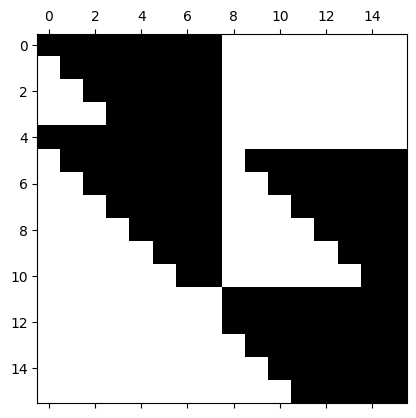

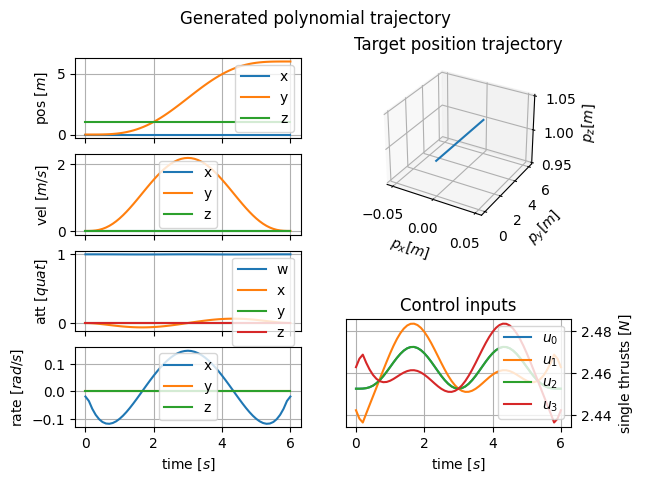

In [194]:
ps = [[0, 0, 0], [1,0,1], [0,1,0]]
yaws = [0, 0, 0]

discretization_dt = 0.1

n = 3
pos_traj = np.zeros((n, 3))
pos_traj[:, 1] = np.linspace(-3, 3, n)
pos_traj[:, 2] = 1
att_traj = np.zeros_like(pos_traj)

av_dist = np.mean(np.sqrt(np.sum(np.diff(pos_traj, axis=0) ** 2, axis=1)))
av_dt = av_dist / 1

poly_pos_traj = fit_multi_segment_polynomial_trajectory(pos_traj.T, att_traj[:, -1].T)

traj, yaw, t_ref = get_full_traj(poly_pos_traj, target_dt=av_dt, int_dt=discretization_dt)

plot = True

reference_traj, t_ref, reference_u = minimum_snap_trajectory_generator(traj, yaw, t_ref, qr, None, plot)
# fit_multi_segment_polynomial_trajectory(p_targets, yaw_targets)

In [393]:
def generate_m(n_points, nth_der = 4):
    # f_n(t) = c0n + c1n*t + c2n*t^2 + ... = x(n+1) at t = 1 for trajectory n
    # f_n+1(t) = d0n + d1n*t + d2n*t^2 + ... = x(n+1) at t = -1 for trajectory n+1 (solve for position state x)
    # df_n(t) = c1n + 2*c2n*t + ...
    # df_n+1(t) = d1n + 2*d2n*t + ...
    # ddf_n(t) = etc
    # ddf_n+1(t) = etc
    # all derivatives at point n should be equal to all derivatives at 0+1 at point n + 1 for time + and -1 respectively.
    # Assure a square matrix, then the polynomial can be deduced
    # for the starting and final position, velocity, acceleration and jerk custom values can be applied, if not given, vel, acc and jerk are all zero

    # First start with the consitions where n != 0 or n != 0

    # [f_n(1), zeros()] = x(n+1)
    # [zeros(), f_n+1(-1)] = x(n+1)
    # [df_n(1), -df_n+1(-1)] = 0
    # [ddf_n(1), -ddf_n+1(-1)] = 0
    # ...
    # ...

    # for start and end condition we need an 8 by 8

    m_start = matrix_generation(-1)[:2*nth_der, :2*nth_der]
    m_end = matrix_generation(1)[:2*nth_der, :2*nth_der]

    n_points -= 1

    m_init = m_start[1:nth_der, :]
    m_final = m_end[1:nth_der, :]

    m_intermediate_start = m_start[0, :]
    m_intermediate_end = m_end[0, :]

    m_intermediate_start_ders = m_start[1:-1, :]
    m_intermediate_end_ders = m_end[1:-1, :]

    if n_points > 1:

        pos_conditions = block_diag(*[np.vstack((m_intermediate_start, m_intermediate_end)) for _ in range(n_points)])

        derivative_start_end_conditions = np.zeros((2 * (nth_der - 1), pos_conditions.shape[1]))
        derivative_start_end_conditions[:m_init.shape[0], :m_init.shape[1]] = m_init
        derivative_start_end_conditions[-m_final.shape[0]:, -m_final.shape[1]:] = m_final

        # init matrix size
        temp_intermediate_end = np.zeros(((n_points - 1) * m_intermediate_start_ders.shape[0], (n_points) * m_intermediate_start_ders.shape[1]))
        temp_intermediate_start = np.zeros(((n_points - 1) * m_intermediate_start_ders.shape[0], (n_points) * m_intermediate_start_ders.shape[1]))

        # create block matrices for start and end intermiedate condition
        end_block_diag = block_diag(*[m_intermediate_end_ders for _ in range(n_points - 1)])
        start_block_diag = block_diag(*[-m_intermediate_start_ders for _ in range(n_points - 1)])

        # add to empty init matrix
        temp_intermediate_end[:,:end_block_diag.shape[1]] = end_block_diag
        temp_intermediate_start[:,-start_block_diag.shape[1]:] = start_block_diag

        derivative_intermediate_condition = temp_intermediate_end + temp_intermediate_start

        return np.vstack((pos_conditions, derivative_start_end_conditions, derivative_intermediate_condition))
    else:
        return np.vstack((m_intermediate_start, m_intermediate_end, m_init, m_final))

def generate_x(m_poly, pos_traj, vel_boundary = None, acc_boundary = None, jerk_boundary = None):
    x_pos = np.repeat(pos_traj, 2)[1:-1]

    vel_boundary = vel_boundary if vel_boundary is not None else np.zeros(2)
    acc_boundary = acc_boundary if acc_boundary is not None else np.zeros(2)
    jerk_boundary = jerk_boundary if jerk_boundary is not None else np.zeros(2)

    x_der_init = np.array((vel_boundary, acc_boundary, jerk_boundary)).reshape(-1, 1).flatten()

    x_intermediate = np.zeros(m_poly.shape[0] - len(x_pos) - len(x_der_init))
    return np.concatenate((x_pos, x_der_init, x_intermediate), axis=None)

def solve_trajectory(pos_traj, vel_boundaries = None, acc_boundaries = None, jerk_boundaries = None):
    pos_traj = np.asarray(pos_traj)
    if len(pos_traj.shape) == 1:
        pos_traj = pos_traj[np.newaxis]

    vel_boundaries = np.asarray(vel_boundaries) if vel_boundaries is not None else np.zeros((pos_traj.shape[0], 2))
    acc_boundaries = np.asarray(acc_boundaries) if acc_boundaries is not None else np.zeros((pos_traj.shape[0], 2))
    jerk_boundaries = np.asarray(jerk_boundaries)if jerk_boundaries is not None else np.zeros((pos_traj.shape[0], 2))

    poly_bucket = []
    for i, traj in enumerate(pos_traj):

        n_points = len(traj)
        m_poly = generate_m(n_points)
        y_poly = generate_x(m_poly, traj, )
        poly_res = np.linalg.solve(m_poly, y_poly).reshape(-1, 8)
        poly_bucket.append(poly_res)

    return poly_bucket


def get_refs(poly_coeffs, point_target_time, delta_time):

    # Adjust target_dt to make it divisible by int_dt
    target_dt = round(target_dt / delta_time) * delta_time

    # Assign target time for each keypoint using homogeneous spacing
    t_vec = np.arange(0, target_dt * (poly_coeffs.shape[0] + 1) - 1e-5, target_dt)

    for seg in range(len(t_vec) - 1):

        # Select time sampling (linear or quadratic) mode
        tau_dt = np.arange(t_vec[seg], t_vec[seg + 1] + 1e-5, delta_time)

        # Re-normalize time sampling vector between -1 and 1
        t1 = (tau_dt - t_vec[seg]) / (t_vec[seg + 1] - t_vec[seg]) * 2 - 1

        # Compression ratio
        compress = 2 / np.diff(t_vec)[seg]

        # Integrate current segment of trajectory
        traj = np.zeros((4, dims, len(t1)))

        for der_order in range(4):
            for i in range(dims):
                traj[der_order, i, :] = np.polyval(np.polyder(poly_coeffs[seg, :, i], der_order), t1) * (compress ** der_order)

        if seg < len(t_vec) - 2:
            # Remove last sample (will be the initial point of next segment)
            traj = traj[:, :, :-1]
            t_seg = tau_dt[:-1]
        else:
            t_seg = tau_dt

        full_traj = np.concatenate((full_traj, traj), axis=-1)
        t_total = np.concatenate((t_total, t_seg))

    # Separate into p_xyz and yaw trajectories
    yaw_traj = full_traj[:, -1, :]
    full_traj = full_traj[:, :-1, :]

    return full_traj, yaw_traj, t_total




traj = [[0., 1., -1.], [-1,3,1]]
poly_trajectory = solve_trajectory(traj)






[array([[ 0.38413086,  1.01616211,  0.45834961, -0.68188477, -0.43237305,
          0.20200195,  0.08989258, -0.0362793 ],
        [-0.47475586, -1.47758789,  0.91977539,  0.63061523, -0.55200195,
         -0.19174805,  0.10698242,  0.0387207 ]]),
 array([[ 0.05048828,  2.95517578,  1.83955078, -1.26123047, -1.10400391,
          0.38349609,  0.21396484, -0.07744141],
        [ 1.76826172, -2.03232422,  0.91669922,  1.36376953, -0.86474609,
         -0.40400391,  0.17978516,  0.07255859]])]

In [397]:
poly_trajectory[0].shape


(2, 8)

In [375]:
pos_traj = np.asarray(np.array([[1, 2, 3], [0,0,0], [0,0,0]]))

np.zeros((pos_traj.shape[0], 2))

array([[0., 0.],
       [0., 0.],
       [0., 0.]])

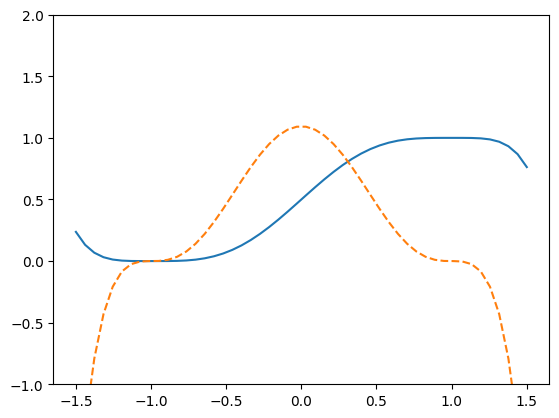

In [367]:
polys = poly_res[0]
polysd = np.polynomial.polynomial.polyder(polys, axis=0)

xp = np.linspace(-1.5, 1.5)

plt.ylim(-1,2)

plt.plot(xp, np.polynomial.polynomial.polyval(xp, polys), '-', xp, np.polynomial.polynomial.polyval(xp, polysd), '--')

In [ ]:

xa = 0.
va = 0.
aa = 0.
ja = 0.

xb = 1. # this has to be explicit
### this equals at t = 1 for the first segments equals this for t = -1 for the second time segment
# vb = 0. 
# ab = 0.
# jb = 0.

xb = 1.
# vb = 0.
# ab = 0.
# jb = 0.

xc = 2.
vc = 0.
ac = 0.
jc = 0.

A = np.vstack((m_minus[:4, :], m_one[:4, :]))
B = np.array([xa, va, aa, ja, xc, vc, ac, jc])

polys = np.linalg.solve(A,B) #[0]
polysd = np.polynomial.polynomial.polyder(polys, axis=0)

xp = np.linspace(-1.5, 1.5)

plt.ylim(-1,2)

plt.plot(xp, np.polynomial.polynomial.polyval(xp, polys), '-', xp, np.polynomial.polynomial.polyval(xp, polysd), '--')

# polys

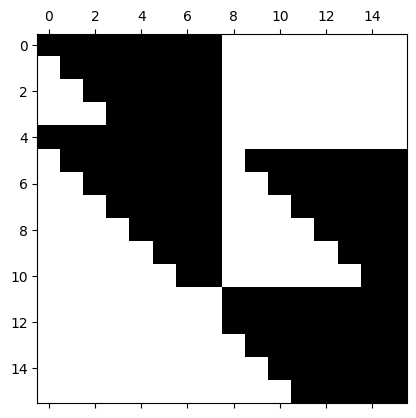

In [277]:
aaa = multiple_waypoints(2)

plt.spy(aaa)

In [174]:
# https://stackoverflow.com/questions/67984130/how-to-fit-a-polynomial-when-the-values-of-derivatives-are-constrained

TypeError: Cannot convert expression to float